In [4]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from seshatdatasetanalysis import TimeSeriesDataset as TSD
from seshatdatasetanalysis import Template
from seshatdatasetanalysis.utils import download_data, weighted_mean

In [5]:
dataset = TSD(file_path='100_yr_dataset.xlsx')

Dataset loaded from c:\Users\mperuzzo\OneDrive - Nexus365\Documents\SeshatDatasetAnalysis\test_scripts\100_yr_dataset.xlsx


C:\Users\mperuzzo\AppData\Local\Temp\ipykernel_37272\2498210535.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mask[col].loc[dataset.scv[col].notna()] = random_pick
c:\Users\mperuzzo\OneDrive - Nexus365\Documents\SeshatDatasetAnalysis\

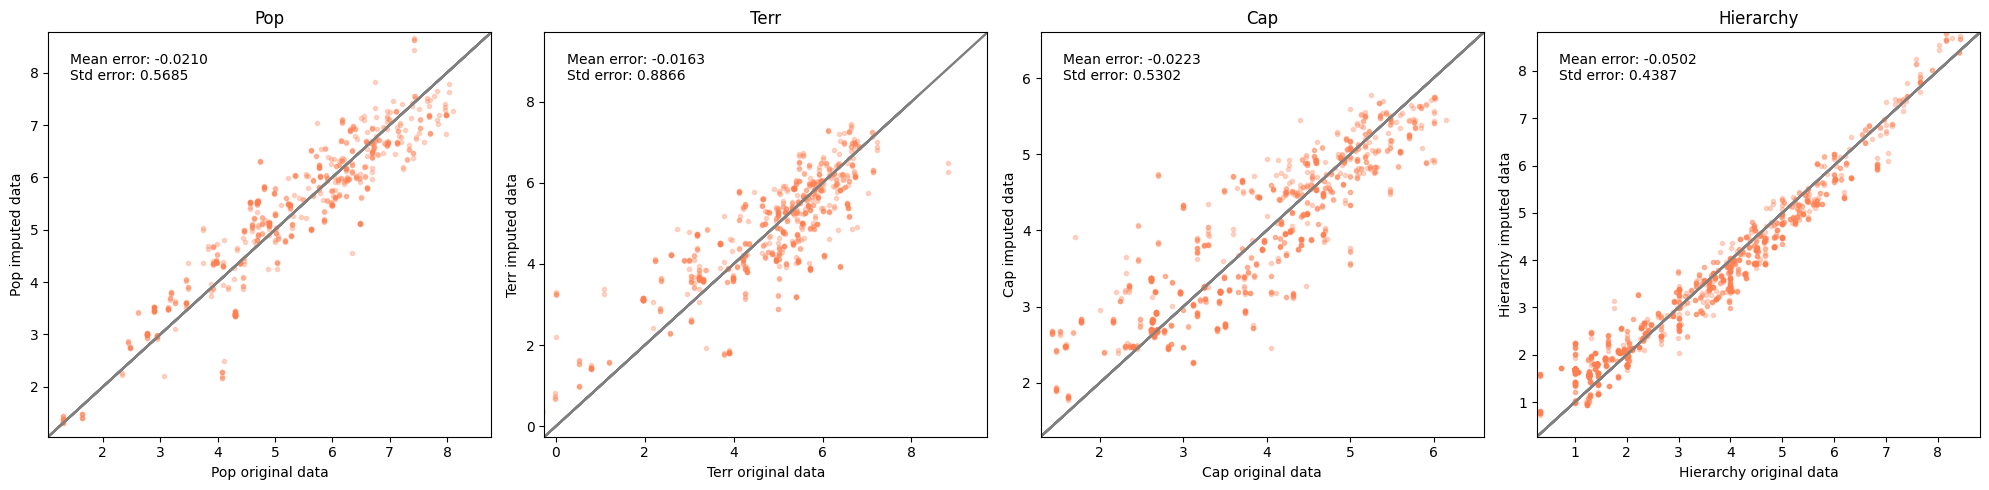

In [56]:
# reset scv by building social complexity
dataset.build_social_complexity()
# store original scv
dataset.scv['Hierarchy2'] = dataset.scv['Hierarchy'] ** 2
old_scv = dataset.scv.copy()
dataset.scv_imputed = pd.DataFrame()

# decide on columns to impute
imputation_columns = ['Pop', 'Terr', 'Cap', 'Hierarchy', 'Hierarchy2'] # ['Government','Infrastructure','Information','Money']
to_impute = ['Pop', 'Terr', 'Cap', 'Hierarchy']

n_runs = 10

# initiate dataset for all errors
error_db = pd.DataFrame(index=range(n_runs), columns=to_impute)

# initiate plot
fig,axes = plt.subplots(int(np.ceil(len(to_impute)/4)),4, figsize=(20,5*int(np.ceil(len(to_impute)/4))))
ax = axes.flatten()

for run in range(n_runs):
    # create a random mask for 10% of not nan data in imputation_columns
    mask = pd.DataFrame(False, index=dataset.scv.index, columns=to_impute)
    for c,col in enumerate(to_impute):
        # find amount on not nans in variable
        non_zero_len = dataset.scv[col].notna().sum()
        # assign a random 10% of not nans to be masked
        random_pick = np.random.rand(non_zero_len) < 0.1
        mask[col].loc[dataset.scv[col].notna()] = random_pick
        mask[col] = mask[col] & dataset.scv[col].notna()
        # set those values to nan
        dataset.scv.loc[mask[col], col] = np.nan
        # impute only the current column
        dataset.impute_missing_values(imputation_columns, use_duplicates = True, r2_lim = 0, add_resid = False, only_impute_cols = [col])
    
        # compare to old_scv to see how well the imputation worked
        errors = (old_scv[mask[col]][col] - dataset.scv_imputed[mask[col]][col])
        mse = np.mean(errors ** 2)
        error_db.loc[run, col] = np.array(errors)
        # plot original vs imputed for current column
        max_val = max(old_scv[mask[col]][col].max(),dataset.scv_imputed[mask[col]][col].max())*1.1
        min_val = min(old_scv[mask[col]][col].min(),dataset.scv_imputed[mask[col]][col].min())*0.8
        ax[c].plot(old_scv[mask[col]][col],dataset.scv_imputed[mask[col]][col],'.', color = 'coral', alpha = 0.3)
        ax[c].set_xlim(min_val,max_val)
        ax[c].set_ylim(min_val,max_val)
        ax[c].set_title(col)
        ax[c].set_xlabel(col + ' original data')
        ax[c].set_ylabel(col + ' imputed data')
        ax[c].plot([min_val,max_val],[min_val,max_val],'-', color = 'gray')

        # reset dataset scv and imputation fits
        dataset.scv = old_scv.copy()
        dataset.imputation_fits = []

errors_means = pd.DataFrame(index=imputation_columns, columns=['mean', 'std'])

# after all runs compute mean and std of errors and annotate plots
for col in to_impute:

    all_errors = np.concatenate(error_db[col])
    all_errors = [e for e in all_errors if (not np.isnan(e)) and (not np.isinf(e))]
    errors_means.loc[col, 'mean'] = np.mean(all_errors)
    errors_means.loc[col, 'std'] = np.std(all_errors)
    ax[imputation_columns.index(col)].annotate(f'Mean error: {errors_means.loc[col, "mean"]:.4f}\nStd error: {errors_means.loc[col, "std"]:.4f}', 
                                               xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, 
                                               verticalalignment='top')
plt.tight_layout()
plt.show()

# dataset.impute_missing_values(imputation_columns, use_duplicates = False, r2_lim = 0.0, add_resid = False)


In [57]:
dataset.impute_missing_values(imputation_columns, use_duplicates = True, r2_lim = 0, add_resid = False, only_impute_cols = to_impute)

c:\Users\mperuzzo\OneDrive - Nexus365\Documents\SeshatDatasetAnalysis\seshatdatasetanalysis\TimeSeriesDataset.py:393: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fits = pd.concat([df_fits, pd.DataFrame([fit_row_dict], columns=df_fits.columns)], ignore_index=True)


Text(0.5, 1.0, 'Missing values per column before imputation')

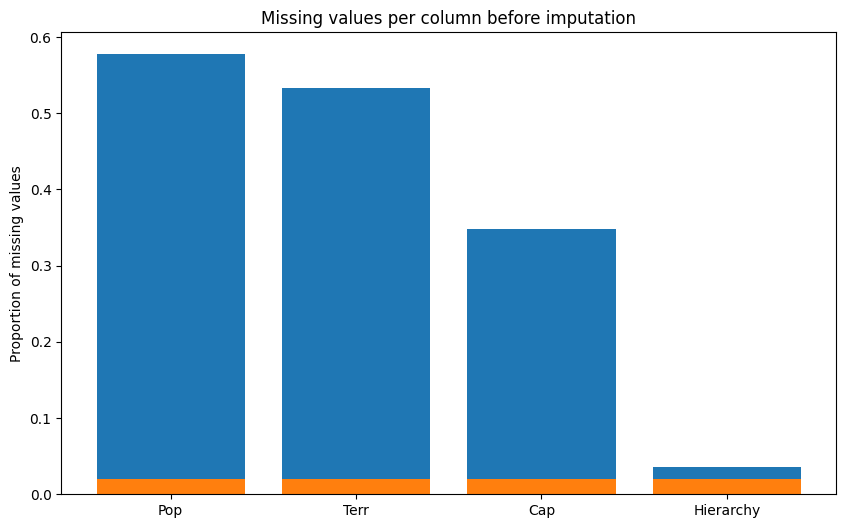

In [59]:
nan_vals = old_scv.isna().sum()[to_impute]/len(dataset.scv)
nan_imputed = dataset.scv_imputed.isna().sum()[to_impute]/len(dataset.scv_imputed)
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(to_impute, nan_vals)
ax.bar(to_impute, nan_imputed)
ax.set_ylabel('Proportion of missing values')
ax.set_title('Missing values per column before imputation')

In [62]:
from sklearn.impute import KNNImputer

C:\Users\mperuzzo\AppData\Local\Temp\ipykernel_37272\1919790237.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mask[col].loc[dataset.scv[col].notna()] = random_pick
C:\Users\mperuzzo\AppData\Local\Temp\ipykernel_37272\1919790237.py:30:

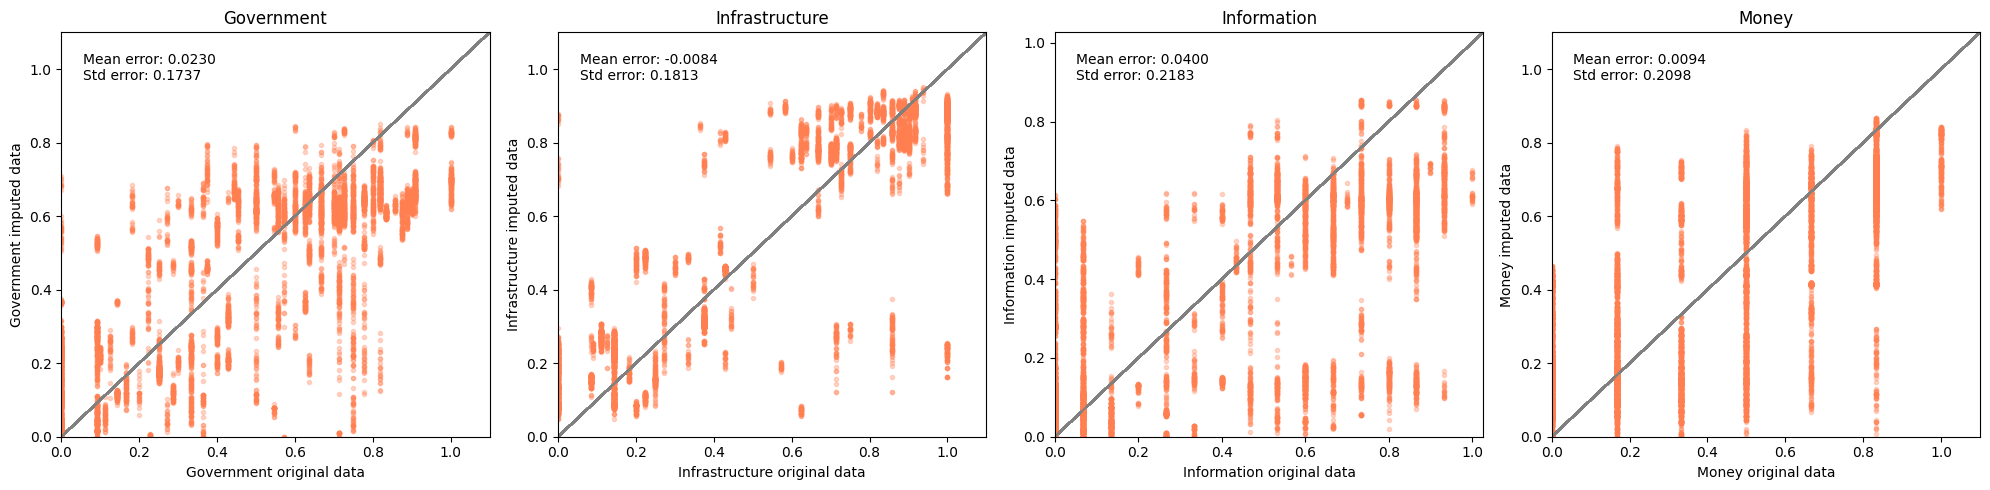

In [73]:
# reset scv by building social complexity
dataset.build_social_complexity()
# store original scv
dataset.scv['Hierarchy2'] = dataset.scv['Hierarchy'] ** 2
old_scv = dataset.scv.copy()
dataset.scv_imputed = pd.DataFrame()

# decide on columns to impute
imputation_columns = ['Government','Infrastructure','Information','Money']
to_impute = ['Government','Infrastructure','Information','Money']
imputer = KNNImputer(n_neighbors=50)

n_runs = 100

# initiate dataset for all errors
error_db = pd.DataFrame(index=range(n_runs), columns=to_impute)

# initiate plot
fig,axes = plt.subplots(int(np.ceil(len(to_impute)/4)),4, figsize=(20,5*int(np.ceil(len(to_impute)/4))))
ax = axes.flatten()

for run in range(n_runs):
    # create a random mask for 10% of not nan data in imputation_columns
    mask = pd.DataFrame(False, index=dataset.scv.index, columns=to_impute)
    for c,col in enumerate(to_impute):
        # find amount on not nans in variable
        non_zero_len = dataset.scv[col].notna().sum()
        # assign a random 10% of not nans to be masked
        random_pick = np.random.rand(non_zero_len) < 0.1
        mask[col].loc[dataset.scv[col].notna()] = random_pick
        mask[col] = mask[col] & dataset.scv[col].notna()
        # set those values to nan
        dataset.scv.loc[mask[col], col] = np.nan
        # impute only the current column
        dataset.scv_imputed[imputation_columns] = imputer.fit_transform(dataset.scv[imputation_columns])
    
        # compare to old_scv to see how well the imputation worked
        errors = (old_scv[mask[col]][col] - dataset.scv_imputed[mask[col]][col])
        mse = np.mean(errors ** 2)
        error_db.loc[run, col] = np.array(errors)
        # plot original vs imputed for current column
        max_val = max(old_scv[mask[col]][col].max(),dataset.scv_imputed[mask[col]][col].max())*1.1
        min_val = min(old_scv[mask[col]][col].min(),dataset.scv_imputed[mask[col]][col].min())*0.8
        ax[c].plot(old_scv[mask[col]][col],dataset.scv_imputed[mask[col]][col],'.', color = 'coral', alpha = 0.3)
        ax[c].set_xlim(min_val,max_val)
        ax[c].set_ylim(min_val,max_val)
        ax[c].set_title(col)
        ax[c].set_xlabel(col + ' original data')
        ax[c].set_ylabel(col + ' imputed data')
        ax[c].plot([min_val,max_val],[min_val,max_val],'-', color = 'gray')

        # reset dataset scv and imputation fits
        dataset.scv = old_scv.copy()
        dataset.imputation_fits = []

errors_means = pd.DataFrame(index=imputation_columns, columns=['mean', 'std'])

# after all runs compute mean and std of errors and annotate plots
for col in to_impute:

    all_errors = np.concatenate(error_db[col])
    all_errors = [e for e in all_errors if (not np.isnan(e)) and (not np.isinf(e))]
    errors_means.loc[col, 'mean'] = np.mean(all_errors)
    errors_means.loc[col, 'std'] = np.std(all_errors)
    ax[imputation_columns.index(col)].annotate(f'Mean error: {errors_means.loc[col, "mean"]:.4f}\nStd error: {errors_means.loc[col, "std"]:.4f}', 
                                               xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, 
                                               verticalalignment='top')
plt.tight_layout()
plt.show()

# dataset.impute_missing_values(imputation_columns, use_duplicates = False, r2_lim = 0.0, add_resid = False)
